In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split,Subset
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Data preprocessing and Data augmentation
train_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# 2. Loading the data (assuming the folder structure is data_raw/focused and data_raw/distracted)
data_dir = 'drive/MyDrive/dataset_raw'
dataset = datasets.ImageFolder(data_dir, transform=None)

# 70% train,20% validation，10% test
train_size = int(0.7 * len(dataset))
val_size=int(0.2 * len(dataset))
test_size = len(dataset) - (train_size+val_size)

generator = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset= random_split(dataset, [train_size, val_size,test_size],generator=generator)

train_data = Subset(
    datasets.ImageFolder(data_dir, transform=train_transform),
    train_subset.indices
)

val_data = Subset(
    datasets.ImageFolder(data_dir, transform=test_transform),
    val_subset.indices
)

test_data = Subset(
    datasets.ImageFolder(data_dir, transform=test_transform),
    test_subset.indices
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
def train_model():

    # model = models.resnet18(pretrained=True)
    model = models.resnet18(pretrained=False)
    # Freeze layers and train the last layer
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 4. Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    # 5. Training Loop
    print("Start training...")
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # 6. Save model
    torch.save(model.state_dict(), "attention_model.pth")
    print("The model has been saved as attention_model.pth")
train_model()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Start training...
Epoch 1, Loss: 0.7073196868101755
Epoch 2, Loss: 0.6843493216567569
Epoch 3, Loss: 0.7047786712646484
Epoch 4, Loss: 0.7222238381703695
Epoch 5, Loss: 0.6494299438264635
The model has been saved as attention_model.pth


Successfully loaded model weights from attention_model.pth

Final Test Accuracy: 55.70 %
Average Inference Latency: 1.22 ms per image
FPS (Frames Per Second): 817.81


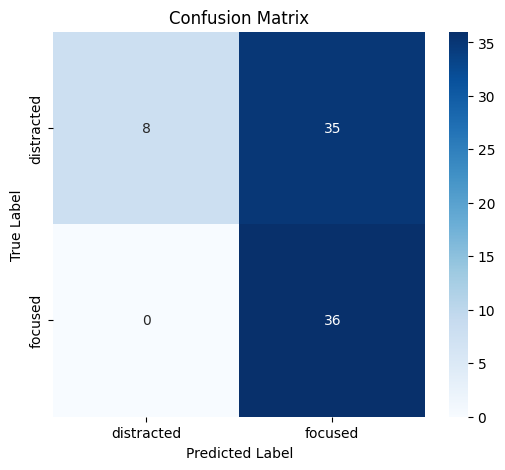


Detailed Classification Report:
              precision    recall  f1-score   support

  distracted       1.00      0.19      0.31        43
     focused       0.51      1.00      0.67        36

    accuracy                           0.56        79
   macro avg       0.75      0.59      0.49        79
weighted avg       0.78      0.56      0.48        79



In [ ]:
def test_model(test_loader: DataLoader, model_path: str):

    model = models.resnet18(weights=None)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    try:
        model.load_state_dict(torch.load(model_path))
        print(f"Successfully loaded model weights from {model_path}")
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return

    model.eval()

    all_preds = []
    all_labels = []
    inference_times = []

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            if device.type == 'cuda': torch.cuda.synchronize()
            start_time = time.time()
            outputs = model(inputs)
            if device.type == 'cuda': torch.cuda.synchronize()
            end_time = time.time()

            batch_time = end_time - start_time
            inference_times.append(batch_time / inputs.size(0))


            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'\nFinal Test Accuracy: {accuracy:.2f} %')

    #Inference latency
    avg_latency = np.mean(inference_times) * 1000
    fps = 1.0 / np.mean(inference_times)
    print(f"Average Inference Latency: {avg_latency:.2f} ms per image")
    print(f"FPS (Frames Per Second): {fps:.2f}")

    class_names = dataset.class_to_idx.keys()

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

test_model(test_loader, "attention_model.pth")


Successfully loaded model weights from attention_model.pth
Running Inference to find errors...

Analysis Result (Total: 79 images)
Correct: 44
False Positives: 0
False Negatives: 35

[False Positives] Real: Focused -> Pred: Distracted

[False Negatives] Real: Distracted -> Pred: Focused
  - d_1765077692025.jpg
  - d_1764975331312.jpg
  - d_1765077695926.jpg
  - d_1765077720810.jpg
  - d_1765077690025.jpg
  - d_1765077691926.jpg
  - d_1765077693026.jpg
  - d_1765077717901.jpg
  - d_1764975333946.jpg
  - d_1764975335613.jpg

Visualizing a False Negative (Distracted -> Focused):


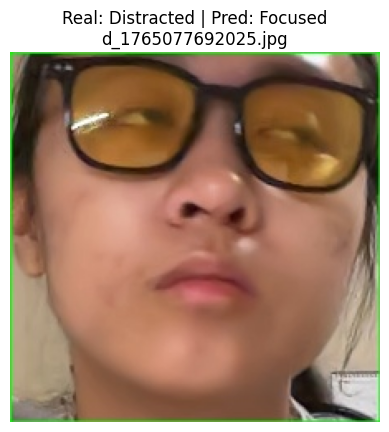

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os

def analyze_model_errors(test_loader, model_path):

  if hasattr(test_loader.dataset, 'class_to_idx'):
        class_mapping = test_loader.dataset.class_to_idx
  elif hasattr(test_loader.dataset, 'dataset') and hasattr(test_loader.dataset.dataset, 'class_to_idx'):
      class_mapping = test_loader.dataset.dataset.class_to_idx

  idx_focused = class_mapping['focused']
  idx_distracted = class_mapping['distracted']

  model = models.resnet18(weights=None)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  try:
      model.load_state_dict(torch.load(model_path))
      print(f"Successfully loaded model weights from {model_path}")
  except FileNotFoundError:
      print(f"Error: Model file not found at {model_path}")
      return

  model.eval()

  if hasattr(test_loader.dataset, 'samples'):
      all_image_paths = [s[0] for s in test_loader.dataset.samples]
  elif hasattr(test_loader.dataset, 'dataset') and hasattr(test_loader.dataset.dataset, 'samples'):
      full_dataset = test_loader.dataset.dataset
      indices = test_loader.dataset.indices
      all_image_paths = [full_dataset.samples[i][0] for i in indices]
  else:
      all_image_paths = []

  all_preds = []
  all_labels = []

  print("Running Inference to find errors...")

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  class_names = dataset.class_to_idx.keys()

  false_positives = []
  false_negatives = []
  corrects = []

  for i in range(len(all_labels)):
      path = all_image_paths[i] if all_image_paths else f"Image_{i}"
      filename = os.path.basename(path)
      true_label = all_labels[i]
      pred_label = all_preds[i]

      info = (filename, path)

      if true_label == idx_focused and pred_label == idx_distracted:
          false_positives.append(info)
      elif true_label == idx_distracted and pred_label == idx_focused:
          false_negatives.append(info)
      else:
          corrects.append(info)

  print(f"\nAnalysis Result (Total: {len(all_labels)} images)")
  print(f"Correct: {len(corrects)}")
  print(f"False Positives: {len(false_positives)}")
  print(f"False Negatives: {len(false_negatives)}")

  print("\n" + "="*50)
  print("[False Positives] Real: Focused -> Pred: Distracted")
  for fname, fpath in false_positives[:10]:
      print(f"  - {fname}")

  print("\n" + "="*50)
  print("[False Negatives] Real: Distracted -> Pred: Focused")
  for fname, fpath in false_negatives[:10]:
      print(f"  - {fname}")

  if false_positives:
      print("\nVisualizing a False Positive (Focused -> Distracted):")
      img_path = false_positives[0][1]
      img = Image.open(img_path)
      plt.imshow(img)
      plt.title(f"Real: Focused | Pred: Distracted\n{os.path.basename(img_path)}")
      plt.axis('off')
      plt.show()

  if false_negatives:
    print("\nVisualizing a False Negative (Distracted -> Focused):")
    img_path = false_negatives[0][1]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Real: Distracted | Pred: Focused\n{os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

analyze_model_errors(test_loader, "attention_model.pth")